# SACC file creation for binned cluster analysis

In [22]:
import math
import itertools
import numpy as np
from astropy.table import Table
from astropy.io import fits
from scipy import stats
import matplotlib.pyplot as plt

# This require Numcosmo v>=0.17
from numcosmo_py import Nc
from numcosmo_py import Ncm

from firecrown.sacc_support import sacc

In [12]:
H0 = 71.0
Ob0 = 0.0448
Odm0 = 0.22
n_s = 0.963
sigma8 = 0.8

cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()

cosmo.props.H0 = H0
cosmo.props.Omegab = Ob0
cosmo.props.Omegac = Odm0

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = n_s

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log((sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude)

In [13]:
# CosmoSim_proxy model
# M_0, z_0

area = 439.78986
lnRl = 0.0
lnRu = 5.0
zl = 0.2
zu = 0.65

# NumCosmo proxy model based on arxiv 1904.07524v2
cluster_z = Nc.ClusterRedshift.new_from_name(
    f"NcClusterRedshiftNodist{{'z-min': <{zl:22.15e}>, 'z-max':<{zu:22.15e}>}}"
)

cluster_m = Nc.ClusterMass.new_from_name(
    f"NcClusterMassAscaso{{'M0':<{3.0e14 / 0.71:22.15e}>,'z0':<0.6>, "
    f"'lnRichness-min':<{lnRl:22.15e}>, 'lnRichness-max':<{lnRu:22.15e}>}}"
)
cluster_m.param_set_by_name("mup0", 3.19)
cluster_m.param_set_by_name("mup1", 2 / np.log(10))
cluster_m.param_set_by_name("mup2", -0.7 / np.log(10))
cluster_m.param_set_by_name("sigmap0", 0.33)
cluster_m.param_set_by_name("sigmap1", -0.08 / np.log(10))
cluster_m.param_set_by_name("sigmap2", 0 / np.log(10))

# Numcosmo Mass Function
# First we need to define the multiplicity function here we will use the tinker
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)  # This reproduces the linear interpolation done in CCL
mulf.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
mulf.set_Delta(200)

# Second we need to construct a filtered power spectrum
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster Abundance Obj
ca = Nc.ClusterAbundance.new(hmf, None)

# Number Counts object
ncount = Nc.DataClusterNCount.new(
    ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso"
)
ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

rng = Ncm.RNG.seeded_new(None, 32)
ncount.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)

ncount.catalog_save("ncount_rich.fits", True)
ncdata_fits = fits.open("ncount_rich.fits")
ncdata_data = ncdata_fits[1].data  # pylint: disable-msg=no-member
ncdata_Table = Table(ncdata_data)

In [14]:
data_table = ncdata_Table[ncdata_Table["LNM_OBS"] > 2]
cluster_z = data_table["Z_OBS"]
cluster_lnm = data_table["LNM_OBS"]
cluster_richness = cluster_lnm / np.log(10.0)
cluster_logM = data_table["LNM_TRUE"] / np.log(10.0)

# ## Count halos in the $N_{\rm richness} \times N_z$ richness-redshift plane

N_richness = 5  # number of richness bins
N_z = 4  # number of redshift bins

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, cluster_logM, "count", bins=[N_z, N_richness]
)

mean_logM = stats.binned_statistic_2d(
    cluster_z,
    cluster_richness,
    cluster_logM,
    "mean",
    bins=[z_edges, richness_edges],
).statistic

std_logM = stats.binned_statistic_2d(
    cluster_z, cluster_richness, cluster_logM, "std", bins=[z_edges, richness_edges]
).statistic

var_mean_logM = std_logM**2 / cluster_counts

# ** Correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins.
# In each redshift bin are the $N_{\rm richness}$ richness bins.**

covariance = np.diag(
    np.concatenate((cluster_counts.flatten(), var_mean_logM.flatten()))
)

In [15]:
# ## Saving in SACC format
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "numcosmo_simulated_redshift_richness"
s_count.add_tracer("cluster_survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_lower, z_upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, z_lower, z_upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    richness_lower, richness_upper = richness_bin
    bin_richness_label = f"rich_{i}"
    s_count.add_tracer(
        "bin_richness", bin_richness_label, richness_lower, richness_upper
    )
    bin_richness_labels.append(bin_richness_label)

#  pylint: disable-next=no-member
cluster_count = sacc.standard_types.cluster_counts
#  pylint: disable-next=no-member
cluster_mean_mass = sacc.standard_types.cluster_mean_mass

counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

mean_logM_and_edges = zip(
    mean_logM.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
    )

for bin_mean_logM, (bin_z_label, bin_richness_label) in mean_logM_and_edges:
    s_count.add_data_point(
        cluster_mean_mass,
        (survey_name, bin_z_label, bin_richness_label),
        bin_mean_logM,
    )

# ### Then the add the covariance and save the file

s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("cluster_redshift_richness_sacc_data.fits", overwrite=True)

In [17]:
s2 = sacc.Sacc.load_fits("./cluster_redshift_richness_sacc_data.fits")

In [19]:
s2.data

[DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_0', 'rich_0'), value=389, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_0', 'rich_1'), value=183, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_0', 'rich_2'), value=78, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_0', 'rich_3'), value=26, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_0', 'rich_4'), value=4, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_1', 'rich_0'), value=591, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_1', 'rich_1'), value=259, ),
 DataPoint(data_type='cluster_counts', tracers=('numcosmo_simulated_redshift_richness', 'bin_z_1', 'rich_2'), value=101, ),
 DataPoint(d

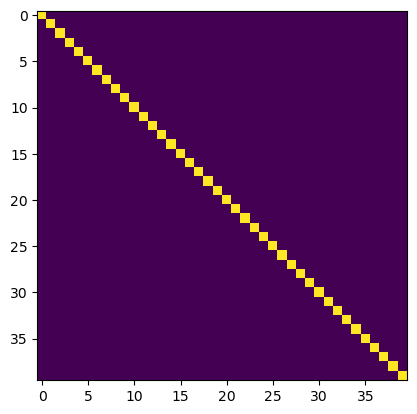

In [23]:
plt.imshow(np.corrcoef(s2.covariance.covmat))